## GPC Calculation Notebook

***************

This notebook contains equations to help calculate the molecular weight from an unbaselined text file from our GPC, using polystyrene references. Those values are hardcoded here, but can be changed easily. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
import numpy as np
from scipy.interpolate import interp1d

Ok, what's the strategy. Find a baseline, then sum across all the values. Simple and easy. Convert all the summed x values into mass from a spline fit or at least a cubic fit of the polystyrene. Offer an option to switch between several fitting models. 

Ok, we'll start by importing the raw data from the GPC, in the form of a .txt file (include the .txt extension). Don't make any modifications to the raw data - This assumes that we'll have a certain format to the head of the data with a bunch of blank lines. Here you should modify the line of code to find your specific data.

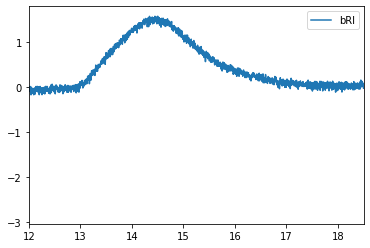

Please select a left limit 12.9
Please select a right limit 17
channel is bRI
Number Average Molecular Weight for bRI is: 18628.9
Weight Average Molecular Weight bRI is: 30070.6
Dispersity bRI is: 1.614
This is the plot of channel bRI
Do you want to save this figure? Type y for yes, n for no. y
What do you want the name of this plot to be? adfg


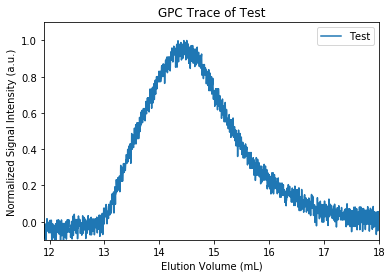

In [8]:
wrapper("2019-08-02_12;32;01_JO3-83_PostSox_P3MEGT_01-THF PS Conv Calibration-0007.txt", ["RI"], "spline", 3, 1, plot_label = ['Test'])

In [2]:
def wrapper (file_data, channels, mw_type = "spline", mw_order = 3, base_order = 1, plot = True, plot_label = [None]):
    """If using multiple channels, use a list of left and right limits, with the order being the same as the order 
    of the channels. Include the .txt extension for the file data."""
    #This is the current GPC Calibration Values
    MW_list = [141000, 65000, 30000, 13000, 4000, 1820]
    RV_list = [13.0133, 13.5433, 14.3800, 15.3967, 16.9233, 18.1000]
    
    raw_data = pd.read_csv(str(file_data), sep = "\s+", header = 13)
    #Remove extra stuff that comes from the way that the import is done, and the way the filestructure is. 
    clean_data = data_clean(raw_data)
    #Apply a baseline across all the channels. 
    base_data = baseline_data(clean_data, base_order)
    #Put into the table the molecular weight data. 
    if mw_type == "spline":
        interpolation = spline_interpolate(mw_order, RV_list, MW_list)
    if mw_type == "polynomial":
        interpolation = poly_interpolate(mw_order, RV_list, MW_list)
    #Assign the data's molecular weight.
    base_data['MW'] = interpolation(base_data['Ret. Vol.'])
    #Loop through the full list of channels, doing calculations for every channel.
    x = 0
    while x < len(channels):
        #First, display the current status for the channel, showing graphs of that channel, so user can select limits.
        plt.plot(base_data['Ret. Vol.'], base_data['b' +  str(channels[x])], label = 'b' + str(channels[x]))
        plt.xlim(12, 18.5)
        plt.legend()
        plt.show()
        left_lim = float(input("Please select a left limit "))
        right_lim = float(input("Please select a right limit "))
        bchannel = 'b' + str(channels[x])
        Weight_Calculation(bchannel, left_lim, right_lim, base_data)
        if plot == True:
            graph_single(bchannel, left_lim, right_lim, base_data, plot_label[x])
        x += 1

In [3]:
def data_clean(input_data):
    signals_list = ["RI", "UV", "RALS", "LALS", "IV-DP", "IV-IP"]
    data = input_data.iloc[:, :7].copy()
    data.columns = ["Ret. Vol."]  + signals_list
    return data

In [4]:
def baseline_data(clean_data, order):
    """Baseline all channels, using PeakUtils. Order is the order of polynomial used to fit a baseline.
    Generally, and order of 1 is recommended, and is the default option if no specific number is passed."""
    signals_list = ["RI", "UV", "RALS", "LALS", "IV-DP", "IV-IP"]
    base_data = clean_data.copy()
    for x in signals_list:
    #Note that default tol of 0.001 is too small, and causes linear values to have problems. Generally linear baseline
    #is best for our purposes, but modify deg to whatever you want I guess. 
        base = peakutils.baseline(base_data[str(x)], deg = order, max_it = 100000, tol = .05)
        base_data['b' + str(x)] = base_data[str(x)]-base
    return base_data

In [5]:
#With baselined data, now we need to translate ret vol into a molecular weight. We'll use a couple of different 
#Options, which will be made as functions. Call the one that works right for your use case. Default is cubic.
def spline_interpolate(order, x, y):
    if order == 3:
        interpolate = interp1d(x, y, kind = 'cubic', bounds_error = False, fill_value = 'extrapolate')
    if order == 1:
        interpolate = interp1d(x, y, bounds_error = False, fill_value = 'extrapolate')
    return interpolate

def polynomial_interpolate(order, x, y):
    interpolate = np.polynomial.polynomial.Polynomial.fit(x, y, deg = order, domain = [0,30])
    return interpolate

In [6]:
#With our MW data, we can now make calculations of Mn and Mw from each of our channels, excluding LS channels. 
#We need to customize by choosing what our limits are for integration, and our channel
#NOTE: The limits you choose result in extreme variations. Check closely and make sure you get it exactly right.
##### Go for making this general by hecking if the channel is BLALS or bRALS, and changing what funct is called.
def Weight_Calculation(channel, left_lim, right_lim, base_data):
       
    if channel == "bRI" or "bUV":
        print("channel is " + str(channel))
        Mn, Mw = Weight_Calculation_NoScat(channel, left_lim, right_lim, base_data)
    
    if channel == "bRALS" or "bLALS":
        Mn, Mw = Weight_Calculation_Scat(channel, left_lim, right_lim, base_data)
    
    dispersity = Mw/Mn
    print("Number Average Molecular Weight for " + str(channel) + " is: " + str(round(Mn, 1)))
    print("Weight Average Molecular Weight " + str(channel) + " is: " + str(round(Mw, 1)))
    print("Dispersity " + str(channel) + " is: " + str(round(dispersity, 3)))
    
    
def Weight_Calculation_NoScat(channel, left_lim, right_lim, base_data):
    number = 0 
    counts = 0
    weight = 0
    for x, y, mass in zip(base_data['Ret. Vol.'], base_data[str(channel)], base_data['MW']):
        if x > left_lim and x < right_lim:
            number += (y*mass)
            weight += (y*mass*mass)
            counts += y
    Mn = number/counts
    Mw = weight/number
    return Mn, Mw
    
def Weight_Calculation_Scat(channel, left_lim, right_lim, base_data):
    number = 0 
    counts = 0
    weight = 0
    for x, y, mass in zip(base_data['Ret. Vol.'], base_data[str(channel)], base_data['MW']):
        if x > left_lim and x < right_lim:
            #Note, divide anything that is a proxy for intensity by mass to get actual intensity
            number += (y)
            weight += (y*mass)
            counts += (y/mass)
    Mn = number/counts
    Mw = weight/number
    return Mn, Mw

In [7]:
def graph_single(channel, left_lim, right_lim, base_data, label):
    plt.plot(base_data['Ret. Vol.'], (base_data[str(channel)]/base_data[str(channel)].max()), label = label)
    plt.xlim(left_lim - 1, right_lim + 1)
    plt.ylim(-0.1, 1.1)
    plt.title("GPC Trace of " + str(label))
    plt.xlabel("Elution Volume (mL)")
    plt.ylabel("Normalized Signal Intensity (a.u.)")
    plt.legend()
    print("This is the plot of channel " + str(channel))
    save = input("Do you want to save this figure? Type y for yes, n for no. ")
    if save == 'y':
        name = input("What do you want the name of this plot to be? ")
        plt.savefig(fname = str(name) + '.tif', dpi = 600)

In short, we need to integrate. We're using raw intensity as a proxy for counts, and we'll multiply each of the raw intensity values by the value of molecular weight at that exact point.

In addition to regular stuff, in case you want to do something about calculating molecular weight from light scattering, there are some complications. Light scattering has not only an elution volume dependence upon molecular weight, but also a molecular weight dependence on elution volume. In other words, the intensity that is seen on the GPC detectors is not only a function of counts, but also a function of the molecular weight of the polymer. As such, we need to make corrections into the calculation of the molecular weight as compared against the polystyrene standards.

Ok, so once we finish all the prep-work, this step is really pretty straightforward. Because the intensity of the signals are dependent upon the *molecular weight* in addition to the number of chains, the calculations for molecular weight from the signal is different than for RI or UV.

There ya have it! That's all the math, and the graphic generation. Hope this helps!

In [20]:
raw_data = pd.read_csv("2019-08-02_12;32;01_JO3-83_PostSox_P3MEGT_01-THF PS Conv Calibration-0007.txt", sep = "\s+", header = 13)
#This is the current GPC Calibration Values
MW_list = [141000, 65000, 30000, 13000, 4000, 1820]
RV_list = [13.0133, 13.5433, 14.3800, 15.3967, 16.9233, 18.1000]

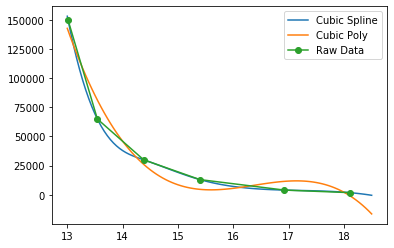

In [201]:
#Just a quick demo on how these different functions perform.
spline_interpolation = spline_interpolate(3, RV_list, mw_list)
poly_interpolation = polynomial_interpolate(3, RV_list, mw_list)
newx = np.linspace(13, 18.5, num = 100)
plt.plot(newx, spline_interpolation(newx), label ="Cubic Spline")
plt.plot(newx, poly_interpolation(newx), label = "Cubic Poly")
plt.plot(RV_list, mw_list, marker = 'o', label = "Raw Data")
plt.legend()